# Galaxy Image Generation with Diffusion Models

Welcome to this tutorial on generating realistic galaxy images using diffusion models! This project demonstrates how to train a sophisticated AI model that can create synthetic galaxy images that are virtually indistinguishable from real astronomical observations.

Diffusion models represent a cutting-edge approach to image generation. Unlike other generative models (like GANs), diffusion models work by gradually adding noise to images and then learning to reverse this process. This approach often leads to more stable training and higher quality outputs, which is crucial when dealing with complex astronomical data.

## Environment Setup

Before we dive into the model implementation, we need to set up our development environment. This section handles all necessary imports and configurations to ensure smooth execution of our training pipeline.

Key components we're setting up:
1. **Deep Learning Framework**: We use PyTorch as our primary framework due to its flexibility and robust GPU support
2. **Data Processing**: NumPy and custom data handlers for efficient galaxy image processing
3. **Progress Tracking**: 
   - TensorBoard for real-time visualization
   - Custom logging for detailed progress tracking
   - TQDM for progress bars
4. **GPU Acceleration**: CUDA configuration for faster training
5. **Warning Management**: Suppression of non-critical warnings to keep our output clean

The code below configures all these components and verifies our setup is ready for training.

In [1]:
# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = INFO, 2 = WARNING, 3 = ERROR

# Import necessary modules
import os
import torch
import torch.nn as nn
import torch.optim as optim
import logging
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random 
import threading
import copy 
from copy import deepcopy
from data_manage import HDF5ImageGenerator  
from modules import EMA, UNet_conditional_conv   
from utils import setup_logging, save_images   
from torch.cuda.amp import GradScaler, autocast
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import math
import torchvision.transforms.functional as F
import subprocess
from IPython.display import clear_output
import warnings
import h5py
import glob
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore', message='You are using `torch.load` with `weights_only=False`')
# Suppress the learning rate scheduler warning
warnings.filterwarnings('ignore', message='The verbose parameter is deprecated.*')

# Suppress the tensorboard log directory warning
warnings.filterwarnings('ignore', message='.*logs will be written to.*')

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Logging Configuration

This section sets up a dual-level logging system for training monitoring and debugging. The code creates three main components:

### 1. Directory Setup
- Creates directories for:
  - Model checkpoints: './Model_Checkpoints'
  - TensorBoard logs: './tens_logs'
  - Training logs: './Logs'

### 2. Logger Configuration
The main logger setup includes:
- Debug level for file logging
- Info level for console output
- Custom timestamp formatting: "HH:MM:SS - LEVEL: MESSAGE"
- Avoids duplicate logging by clearing existing handlers
- Prevents log propagation to parent loggers

### 3. Log Handlers
Two handlers are configured:
- **File Handler**
  - Saves to 'training.log'
  - Captures DEBUG level and above
  - Maintains permanent training record

- **Console Handler**
  - Displays in terminal
  - Shows INFO level and above
  - Provides real-time feedback

In [7]:
# Set up directories
checkpoint_dir = './Model_Checkpoints'
tensorboard_log_dir = "./tens_logs"
logging_dir = './Logs'

# Create necessary directories
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

# Configure logging
log_file = os.path.join(logging_dir, 'training.log')
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Remove existing handlers to avoid duplication
if logger.hasHandlers():
    logger.handlers.clear()

# Prevent log propagation
logger.propagate = False

# Create and configure handlers
file_handler = logging.FileHandler(log_file)
file_handler.setLevel(logging.DEBUG)
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)

# Create and set formatter
formatter = logging.Formatter(
    "%(asctime)s - %(levelname)s: %(message)s",
    datefmt="%I:%M:%S"
)
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Add handlers to logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

logger.info("Logging system initialized")
logger.debug("Debug logging enabled")

## Reproducibility Configuration

This section sets up consistent random number generation across all components to ensure reproducible results. We have two main functions:

### 1. Global Seed Setting
The `set_random_seed` function sets seeds for:
- Python's random module
- NumPy random generator
- PyTorch (CPU operations)
- CUDA (if GPU available)
- CuDNN behavior settings:
  - Deterministic mode enabled
  - Benchmark mode disabled

### 2. Worker Seed Initialization
The `worker_init_fn` function:
- Used by DataLoader workers
- Creates unique seeds for each worker
- Ensures consistent data loading across runs

We use seed=42 as our default random seed for reproducibility.

In [4]:
def set_random_seed(seed):
    # Set seed for Python's built-in random module
    random.seed(seed)
    
    # Set seed for NumPy
    np.random.seed(seed)
    
    # Set seed for PyTorch
    torch.manual_seed(seed)
    
    # If you are using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    
    # For deterministic behavior (may be slower on some systems)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False

In [5]:
seed = 42   
set_random_seed(seed)

In [6]:
def worker_init_fn(worker_id):
    """
    Initialize each worker with a different random seed based on the worker id.
    """
    worker_seed = torch.initial_seed() % 2**32 + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Data Processing and Normalization

This section handles the normalization of our 5-band (g,r,i,z,y) galaxy images and implements validation data selection. We have three main functions:

### 1. Image Normalization
The `normalize_images` function:
- Takes raw galaxy images in all 5 bands
- Normalizes them to [-1, 1] range using pre-computed statistics:
  - Minimum value: -25241.32
  - Maximum value: 3647.6323
- Includes checks for NaN values
- Clips outliers to ensure valid range

### 2. Image Denormalization
The `denormalize_images` function:
- Converts normalized images back to original scale
- Used mainly for visualization and saving results
- Reverses the normalization process exactly

### 3. Validation Batch Selection
The `get_random_val_batch` function:
- Randomly samples a batch of images from validation set
- Checks for empty datasets and NaN values
- Returns both images and their corresponding labels
- Handles errors with appropriate logging

In [8]:
def normalize_images(images):
    """
    Normalize astronomical images to [-1, 1] range using pre-computed dataset statistics.
    
    Args:
        images (torch.Tensor): Raw input images
        
    Returns:
        torch.Tensor: Normalized images in [-1, 1] range
    """
    min_val, max_val = -25241.32, 3647.6323  # Pre-computed statistics
    
    # Input validation
    if torch.isnan(images).any():
        raise ValueError("Input images contain NaN values")
    
    try:
        # Step 1: Scale to [0, 1]
        images = (images - min_val) / (max_val - min_val)
        
        # Clip any potential outliers
        images = torch.clamp(images, 0, 1)
        
        # Step 2: Scale to [-1, 1]
        images = images * 2 - 1
        
        return images
        
    except Exception as e:
        logger.error(f"Normalization failed: {str(e)}")
        raise

def denormalize_images(images):
    """
    Convert normalized images back to original astronomical scale.
    """
    min_val, max_val = -25241.32, 3647.6323
    
    try:
        # Reverse [-1, 1] scaling
        images = (images + 1) / 2
        
        # Reverse [0, 1] scaling
        images = images * (max_val - min_val) + min_val
        
        return images
        
    except Exception as e:
        logger.error(f"Denormalization failed: {str(e)}")
        raise

def get_random_val_batch(val_loader):
    """
    Get a random batch of validation images for visualization.
    """
    val_dataset = val_loader.dataset
    batch_size = val_loader.batch_size
    
    try:
        if len(val_dataset) == 0:
            logger.warning("Empty validation dataset")
            return None, None
            
        # Random sampling with validation
        indices = random.sample(range(len(val_dataset)), batch_size)
        
        images = []
        labels = []
        for idx in indices:
            img, label = val_dataset[idx]
            
            # Validate image and label
            if torch.isnan(img).any():
                logger.warning(f"NaN values found in image at index {idx}")
                continue
                
            images.append(img)
            labels.append(label)
            
        # Stack valid samples
        if not images:
            return None, None
            
        images = torch.stack(images)
        labels = torch.stack(labels)
        
        return images, labels
        
    except Exception as e:
        logger.error(f"Error in random batch selection: {str(e)}")
        return None, None

## Checkpoint Management

This section handles saving and loading model checkpoints, ensuring we can resume training and maintain best models. We have two main functions:

### 1. Saving Checkpoints
The `save_checkpoint` function saves:
- Model state and configuration
- Training progress:
  - Current epoch
  - Loss values
  - Best validation loss
  - Learning rate
  - Batch size
- Random states:
  - Python
  - NumPy
  - PyTorch
  - CUDA (if available)
- Diffusion model parameters:
  - Noise steps
  - Beta start/end values

### 2. Loading Checkpoints
The `load_checkpoint` function:
- Finds and loads the latest checkpoint
- Restores:
  - Model state
  - Optimizer state
  - EMA state (if available)
  - Training parameters
- Ensures all tensors are on correct device
- Returns the last completed epoch number

Both functions include error handling and logging for tracking the checkpoint process.

In [9]:
def save_checkpoint(model, ema, optimizer, epoch, checkpoint_dir, args, average_loss, diffusion, best_val_loss):   
    """
    Enhanced checkpoint saving with better error handling and metadata.

    This function saves the current state of the training process, including the model, optimizer, and other relevant information, to a checkpoint file. The checkpoint can be used to resume training from the saved state later.

    Args:
        model (torch.nn.Module): The model to be saved.
        ema (ExponentialMovingAverage): The Exponential Moving Average (EMA) model, if being used.
        optimizer (torch.optim.Optimizer): The optimizer to be saved.
        epoch (int): The current epoch of training.
        checkpoint_dir (str): The directory where the checkpoint file will be saved.
        args (argparse.Namespace): The command-line arguments used for training.
        average_loss (float): The average training loss for the current epoch.
        diffusion (Diffusion): The diffusion model object.
        best_val_loss (float): The best validation loss achieved so far.
    """
    try:
        # Construct the checkpoint file path
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch:04d}.pth')
        
        # Convert Python's random state tuple to a list of numbers that can be properly serialized
        python_state = random.getstate()
        python_state_list = [python_state[0], list(python_state[1]), python_state[2]]
        
        # Prepare the checkpoint state dictionary
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'ema_state_dict': ema.state_dict() if ema else None,
            'loss': average_loss,
            'best_val_loss': best_val_loss,   
            'learning_rate': args.lr,
            'batch_size': args.batch_size,
            'diffusion_params': {
                'noise_steps': diffusion.noise_steps,
                'beta_start': diffusion.beta_start,
                'beta_end': diffusion.beta_end
            },
            'args': vars(args),
            'random_state': {
                'python': python_state_list,
                'numpy': np.random.get_state(),
                'torch': torch.get_rng_state(),
                'torch_cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,
            },
        }

        # Save the checkpoint
        torch.save(state, checkpoint_path)
        logger.debug(f"Checkpoint saved at epoch {epoch + 1} to {checkpoint_path}")
        
    except Exception as e:
        logger.error(f"Failed to save checkpoint at epoch {epoch + 1}: {e}")
        raise

def load_checkpoint(model, ema, optimizer, checkpoint_dir, args, diffusion, device, start_epoch=None):
    """
    Enhanced checkpoint loading with better error handling and state restoration.

    This function attempts to load the latest checkpoint from the specified checkpoint directory. If a checkpoint is found, it restores the model, optimizer, and other relevant state, allowing the training process to be resumed from the saved state.

    Args:
        model (torch.nn.Module): The model to be loaded.
        ema (ExponentialMovingAverage): The Exponential Moving Average (EMA) model, if being used.
        optimizer (torch.optim.Optimizer): The optimizer to be loaded.
        checkpoint_dir (str): The directory containing the checkpoint files.
        args (argparse.Namespace): The command-line arguments.
        diffusion (Diffusion): The diffusion model object.
        device (torch.device): The device to load the model onto.
        start_epoch (int, optional): The epoch to start from (if not provided, the latest checkpoint is used).

    Returns:
        int: The epoch from which to start training.
    """
    epoch = 0

    try:
        if start_epoch is None:
            # Find the latest checkpoint
            checkpoints = sorted([
                f for f in os.listdir(checkpoint_dir)
                if f.startswith('checkpoint_epoch_') and f.endswith('.pth')
            ])

            if checkpoints:
                # Load the latest checkpoint
                latest_checkpoint = os.path.join(checkpoint_dir, checkpoints[-1])
                checkpoint = torch.load(latest_checkpoint, map_location=device)

                # Load model state and move to device
                model.load_state_dict(checkpoint['model_state_dict'])
                model.to(device)
                logger.debug(f"Model loaded and moved to device {device}")

                # Load optimizer state and ensure device consistency
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                for state in optimizer.state.values():
                    for k, v in state.items():
                        if isinstance(v, torch.Tensor):
                            state[k] = v.to(device)

                # Load EMA state and ensure device consistency
                if 'ema_state_dict' in checkpoint and ema is not None:
                    ema.load_state_dict(checkpoint['ema_state_dict'])
                    for k, v in ema.shadow.items():
                        ema.shadow[k] = v.to(device)
                    logger.debug("EMA state restored from checkpoint")

                # Load additional parameters
                epoch = checkpoint.get('epoch', 0)
                args.lr = checkpoint.get('learning_rate', args.lr)
                args.batch_size = checkpoint.get('batch_size', args.batch_size)

                # Load diffusion parameters if available
                diffusion_params = checkpoint.get('diffusion_params', None)
                if diffusion_params:
                    diffusion.noise_steps = diffusion_params.get('noise_steps', diffusion.noise_steps)
                    diffusion.beta_start = diffusion_params.get('beta_start', diffusion.beta_start)
                    diffusion.beta_end = diffusion_params.get('beta_end', diffusion.beta_end)

                # Return the best validation loss if it exists in the checkpoint
                best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                logger.info(f"Loaded checkpoint from epoch {epoch} with best val loss: {best_val_loss:.4f}")

                logger.info(f"Successfully loaded checkpoint from epoch {epoch}")
            else:
                logger.info("No checkpoints found. Starting from scratch.")

    except Exception as e:
        logger.error(f"Failed to load checkpoint: {e}")
        raise

    return epoch

## Diffusion Model

Our `Diffusion` class implements the core diffusion process with five main methods:

### 1. Initialization
Sets up the diffusion parameters:
- 1000 noise steps
- Beta schedule from 1e-4 to 0.02
- Image size (default 64x64)
- Computes alpha values and cumulative products
- Configures device (CPU/GPU)

### 2. Noise Schedule
`prepare_noise_schedule`:
- Creates linear noise schedule
- Returns evenly spaced values from beta_start to beta_end

### 3. Image Noising
`noise_images`:
- Adds noise to input images
- Takes timestep t as parameter
- Returns both noised image and noise added

### 4. Timestep Sampling
`sample_timesteps`:
- Randomly samples timesteps for training
- Returns integers from 1 to noise_steps

### 5. Image Generation
`sample`:
- Generates n new images from noise
- Uses provided model for denoising
- Conditions on input labels
- Gradually denoises through all timesteps
- Returns generated images

In [10]:
class Diffusion:
   def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
       """
       Initialize diffusion process parameters.
       
       Args:
           noise_steps: Number of steps to add noise (default 1000)
           beta_start: Initial noise level (default 1e-4)
           beta_end: Final noise level (default 0.02)
           img_size: Size of images (default 64x64)
           device: Device to run on (default "cuda")
       """
       # Basic parameters
       self.noise_steps = noise_steps
       self.beta_start = beta_start
       self.beta_end = beta_end
       
       # Create noise schedule
       self.beta = self.prepare_noise_schedule().to(device)
       # Calculate alpha values (1 - beta)
       self.alpha = 1. - self.beta
       # Calculate cumulative products of alpha
       self.alpha_hat = torch.cumprod(self.alpha, dim=0)
       
       self.img_size = img_size
       self.device = device

   def prepare_noise_schedule(self):
       """Create linear noise schedule from beta_start to beta_end"""
       return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

   def noise_images(self, x, t):
       """
       Add noise to images at timestep t
       
       Args:
           x: Input images
           t: Timesteps to add noise at
       Returns:
           Noised images and the noise that was added
       """
       # Get alpha values for timesteps
       sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
       sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
       # Generate random noise
       epsilon = torch.randn_like(x)
       # Return noised image and the noise
       return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

   def sample_timesteps(self, n):
       """Generate n random timesteps between 1 and noise_steps"""
       return torch.randint(low=1, high=self.noise_steps, size=(n,))

   def sample(self, model, n, labels):
       """
       Generate n new images using the diffusion model
       
       Args:
           model: UNet model for noise prediction
           n: Number of images to generate
           labels: Redshift labels to condition on
       """
       logging.info(f"Sampling {n} new images....")
       model.eval()
       with torch.no_grad():
           # Start from random noise
           x = torch.randn((n, 5, self.img_size, self.img_size)).to(self.device)
           
           # Gradually denoise the images
           for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
               t = (torch.ones(n) * i).long().to(self.device)
               # Predict noise at current step
               predicted_noise = model(x, t, labels)
               # Get alpha values for current step
               alpha = self.alpha[t][:, None, None, None]
               alpha_hat = self.alpha_hat[t][:, None, None, None]
               beta = self.beta[t][:, None, None, None]
               
               # Add random noise except at final step
               if i > 1:
                   noise = torch.randn_like(x)
               else:
                   noise = torch.zeros_like(x)
                   
               # Denoising step
               x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
       
       model.train()
       return x

## Best Model Saving

The `save_best_model` function saves the model state when we achieve a new best validation loss. 

### Saved State Components
The function saves:
- Training state:
  - Current epoch
  - Loss values
  - Validation loss
  - Learning rate
  - Batch size
- Model states:
  - Main model
  - Optimizer
  - EMA (if present)
- Configuration:
  - Diffusion parameters
  - Command line arguments
- Random states:
  - Python
  - NumPy
  - PyTorch CPU/CUDA

Includes error handling and logging for tracking save operations.

In [11]:
def save_best_model(model, ema, optimizer, epoch, val_loss, best_model_path, args, average_loss, diffusion):
   """
   Saves the best model based on validation loss with enhanced error handling.
   
   Args:
       model: The UNet model to save
       ema: Exponential Moving Average model
       optimizer: The optimizer state
       epoch: Current epoch number
       val_loss: Current validation loss
       best_model_path: Where to save the model
       args: Training arguments and config
       average_loss: Average training loss
       diffusion: Diffusion model parameters
   """
   try:
       # Create dictionary containing all states we want to save
       state = {
           # Training progress
           'epoch': epoch,                                    # Current epoch
           'loss': average_loss,                             # Training loss
           'val_loss': val_loss,                             # Current validation loss
           'best_val_loss': val_loss,                        # Best validation loss (same as val_loss for best model)
           
           # Model states
           'model_state_dict': model.state_dict(),           # Main model weights
           'optimizer_state_dict': optimizer.state_dict(),    # Optimizer state
           'ema_state_dict': ema.state_dict() if ema else None,  # EMA model weights if exists
           
           # Training configuration
           'learning_rate': args.lr,                         # Current learning rate
           'batch_size': args.batch_size,                    # Batch size used
           
           # Diffusion model parameters
           'diffusion_params': {
               'noise_steps': diffusion.noise_steps,         # Number of noise steps
               'beta_start': diffusion.beta_start,           # Starting noise value
               'beta_end': diffusion.beta_end               # Ending noise value
           },
           
           # Full configuration
           'args': vars(args),                              # All training arguments
           
           # Random states for reproducibility
           'random_state': {
               'python': random.getstate(),                  # Python random state
               'numpy': np.random.get_state(),               # NumPy random state
               'torch': torch.get_rng_state(),               # PyTorch CPU random state
               'torch_cuda': torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None,  # GPU random state
           },
       }
       
       # Save the state dictionary
       torch.save(state, best_model_path)
       logger.debug(f"Best model saved at epoch {epoch + 1} with validation loss {val_loss:.4f}")
       
   except Exception as e:
       # Log error if saving fails
       logger.error(f"Failed to save best model: {e}")
       raise  # Re-raise the exception for the caller to handle

## Training Arguments

The `Args` class defines all training configurations in one place. While these parameters can be modified, we recommend keeping the default values as they've been optimized for galaxy generation, except for the number of epochs which you can adjust based on your training needs.

### Training Parameters
- Batch size: 128 (recommended default)
- Number of epochs: 600 (adjustable based on your needs)
- Learning rate: 5e-5 (recommended default)
- Image size: 64x64 (recommended default)
- Random seed: 42 (recommended default)

### Data Paths
- Training: 5x64x64_training_with_morphology.hdf5
- Validation: 5x64x64_validation_with_morphology.hdf5
- Testing: 5x64x64_testing_with_morphology.hdf5

### Checkpoint Control
Two parameters control how training resumes:
- `resume`: If True, loads from a checkpoint. If False, starts fresh training
- `start_epoch`: 
  - None: Automatically finds and loads the latest checkpoint
  - Integer value: Loads a specific epoch's checkpoint (e.g., 100 for epoch 100)

### Runtime Settings
- Device: CUDA if available, CPU otherwise
- Run name: "DDPM_conditional_continuous"

In [12]:
# Define the Args class
class Args:
    def __init__(self):
        self.resume = True  # Set to True to resume training from the latest checkpoint
        self.run_name = "DDPM_conditional_continuous"
        self.batch_size = 128
        self.epochs = 600
        self.image_size = 64
        self.train_path = r'/shared/astrodata/5x64x64_training_with_morphology.hdf5'
        self.validation_path = r'/shared/astrodata/5x64x64_validation_with_morphology.hdf5'
        self.test_path = r'/shared/astrodata/5x64x64_testing_with_morphology.hdf5'
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.lr = 5e-5
        self.start_epoch = None  # Set this to specify a specific checkpoint epoch, or None for the latest
        self.seed = 42   


## Model Validation

The `validate` function evaluates model performance on the validation dataset. It processes batches of images with the following steps:

### Process Steps
1. Sets model to evaluation mode
2. Disables gradient calculations for efficiency
3. For each batch:
   - Moves images and labels to correct device
   - Normalizes images to [-1, 1] range
   - Adds noise using diffusion process
   - Predicts noise using model
   - Calculates loss
4. Returns average loss across all batches

### Label Handling
Ensures proper label dimensions:
- 0D labels → 2D tensors
- 1D labels → 2D tensors

The function operates without gradients to save memory during validation.

In [14]:
def validate(model, val_loader, diffusion, device, loss_fn):
   """
   Validate the model and return the average validation loss.
   
   Args:
       model: The UNet model being trained
       val_loader: DataLoader for validation data
       diffusion: Diffusion process instance
       device: Device (CPU/GPU) to run validation on
       loss_fn: Loss function (Smooth L1/Huber loss)
   Returns:
       avg_loss: Average loss across all validation batches
   """
   # Set model to evaluation mode (disables dropout, etc.)
   model.eval()
   total_loss = 0.0
   batch_count = 0
   
   # Disable gradient computation for validation
   with torch.no_grad():
       for images, labels in val_loader:
           # Move data to appropriate device
           images = images.to(device)
           labels = labels.float().to(device)
           
           # Ensure labels have correct shape (Batch x 1)
           if labels.dim() == 0:  # Single value
               labels = labels.unsqueeze(0).unsqueeze(1)
           elif labels.dim() == 1:  # Batch of values
               labels = labels.unsqueeze(1)
           
           # Preprocess images and add noise
           images = normalize_images(images)  # Scale to [-1, 1]
           t = diffusion.sample_timesteps(images.size(0)).to(device)  # Get random timesteps
           x_t, noise = diffusion.noise_images(images, t)  # Add noise to images
           
           # Get model's noise prediction
           predicted_noise = model(x_t, t, labels)
           
           # Calculate loss between real and predicted noise
           loss = loss_fn(noise, predicted_noise)
           total_loss += loss.item()
           batch_count += 1
           
   # Calculate average loss across all batches
   avg_loss = total_loss / batch_count
   logger.debug(f"Validation completed with average loss: {avg_loss:.4f}")
   
   # Return model to training mode
   model.train()
   return avg_loss

## Data Loading Setup

This section configures and initializes our data loaders for both training and validation data.

### Data Generator Settings
Configures HDF5 data loading with:
- Input: 'image' (5-band galaxy images)
- Target: 'specz_redshift' (spectroscopic redshift)
  - Range: 0 to 4
  - Represents galaxy's distance/age
  - Used as conditioning for generation
  - Helps model learn redshift-dependent features
- No scaling or augmentation applied
- Smoothing factor: 0.1

### DataLoader Configuration
- Batch size: From Args class
- Workers: 4 parallel loaders
- Pin memory: Enabled for faster GPU transfer
- Shuffle: 
  - Training: Enabled (prevents model from learning batch order)
  - Validation: Disabled (keeps consistent ordering for progress tracking)

The model learns to generate galaxies conditioned on redshift, meaning it can create images of galaxies as they would appear at different distances/ages in the universe.

In [15]:
# Initialize arguments from Args class
args = Args()

# Data generator arguments for training data
train_gen_args = {
   'X_key': 'image',              # Key for accessing image data in HDF5
   'y_key': 'specz_redshift',     # Key for accessing redshift labels
   'scaler': False,               # Don't scale the input images
   'labels_encoding': False,       # No encoding needed for continuous redshift values
   'num_classes': None,           # Not using classification
   'shuffle': True,               # Shuffle data during training
   'y_scaler': False,             # Don't scale the redshift values
   'y_range': (0, 4),            # Redshift range from 0 to 4
   'augmenter': False,            # No data augmentation
   'smooth_factor': 0.1,          # Small smoothing factor for labels
}

# Similar arguments for validation data, but with shuffle=False
val_gen_args = {
   'X_key': 'image',
   'y_key': 'specz_redshift', 
   'scaler': False,
   'labels_encoding': False,
   'num_classes': None,
   'shuffle': False,              # Don't shuffle validation data
   'y_scaler': False,
   'y_range': (0, 4),
   'augmenter': False,
   'smooth_factor': 0.1,
}

# Initialize HDF5 dataset for training
train_dataset = HDF5ImageGenerator(
   src=args.train_path,           # Path to training HDF5 file
   mode='train',                  # Training mode
   X_key='image',                 # Access images in HDF5
   y_key='specz_redshift',        # Access redshifts in HDF5
   scaler=False,                  # Raw image values
   labels_encoding=False,         # Raw redshift values
   num_classes=None,              # Not using classification
   shuffle=False,                 # DataLoader will handle shuffling
   y_scaler=False,               # Keep original redshift scale
   y_range=(0, 4),               # Valid redshift range
   augmenter=False,              # No augmentation
   smooth_factor=0.1             # Small label smoothing
)

# Initialize HDF5 dataset for validation
val_dataset = HDF5ImageGenerator(
   src=args.validation_path,      # Path to validation HDF5 file
   mode='test',                   # Test/validation mode
   X_key='image',
   y_key='specz_redshift',
   scaler=False,
   labels_encoding=False,
   num_classes=None,
   shuffle=False,
   y_scaler=False,
   y_range=(0, 4),
   augmenter=False,
   smooth_factor=0.1
)

# Create PyTorch DataLoader for efficient batching and parallel loading
train_loader = DataLoader(
   train_dataset,
   batch_size=args.batch_size,    # Batch size from Args
   shuffle=True,                  # Shuffle training data
   num_workers=4,                 # Use 4 parallel processes
   pin_memory=True               # Speed up GPU transfer
)

# Validation DataLoader
val_loader = DataLoader(
   val_dataset,
   batch_size=args.batch_size,
   shuffle=False,                 # Don't shuffle validation data
   num_workers=4,                 # Use 4 parallel processes
   pin_memory=True               # Speed up GPU transfer
)

## Data Inspection

This section verifies our dataset is loaded correctly before training begins.

The `inspect_labels` function provides comprehensive data verification:
- Displays the first few galaxy images
- Shows corresponding redshift values
- Verifies data loading and normalization
- Checks for NaN/Inf values
- Optional: Shows histogram distribution of all redshifts

Usage:
```python
# Default: view 3 samples
inspect_labels(train_dataset, device)

# Custom: view 5 samples and show redshift distribution
inspect_labels(train_dataset, device, num_samples=5, plot_histogram=True)
```

In [16]:
def inspect_labels(dataset, device, num_samples=3, plot_histogram=False):
    """
    Inspects labels in the dataset by displaying the first few images with their redshifts
    and optionally plotting a histogram of all redshift labels.
    """
    try:
        # Only print these three pieces of information
        print(f"Dataset type: {type(dataset)}")
        print(f"Dataset length: {len(dataset)}")
        print(f"Accessing indices: {list(range(num_samples))}")
        
        # Get the samples silently
        images_batch, labels_batch = zip(*[dataset[i] for i in range(num_samples)])
        
        # Process without printing
        images_batch = [img.float() for img in images_batch]
        labels_batch = [label.float() if isinstance(label, torch.Tensor) else torch.tensor(label, dtype=torch.float32) for label in labels_batch]

        # Stack tensors and move to device
        images = torch.stack(images_batch).to(device, non_blocking=True)
        labels = torch.stack(labels_batch).to(device)

        # Silently check for NaNs or Infs
        has_nans = torch.isnan(images).any() or torch.isnan(labels).any()
        has_infs = torch.isinf(images).any() or torch.isinf(labels).any()

        # Silently verify label range
        min_label, max_label = labels.min().item(), labels.max().item()
        expected_min, expected_max = 0, 4
        
        # Display images with their corresponding raw redshift labels
        plt.figure(figsize=(15, 5))
        for j in range(num_samples):
            label = labels[j].item()
            # Normalize and prepare image for display
            image_normalized = (images[j] + 1) / 2
            image_normalized = image_normalized.mean(dim=0).cpu().numpy()
            plt.subplot(1, num_samples, j + 1)
            plt.imshow(image_normalized, cmap='gray')
            plt.title(f"Redshift: {label:.4f}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

        if plot_histogram:
            original_labels = []
            # Collect labels with progress bar
            for i in tqdm(range(len(dataset)), desc="Collecting labels for histogram"):
                current_label = dataset[i][1]
                if isinstance(current_label, torch.Tensor):
                    current_label = current_label.item()
                original_labels.append(current_label)

            if original_labels:
                original_labels = np.array(original_labels)
                # Plot histogram without additional prints
                plt.figure(figsize=(10, 6))
                plt.hist(original_labels, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
                plt.title("Redshift Labels Distribution")
                plt.xlabel("Redshift Value")
                plt.ylabel("Frequency")
                plt.grid(axis='y', alpha=0.75)
                plt.tight_layout()
                plt.show()

    except Exception as e_outer:
        print(f"Error during label inspection: {e_outer}")


Dataset type: <class 'data_manage.HDF5ImageGenerator'>
Dataset length: 204573
Accessing indices: [0, 1, 2]


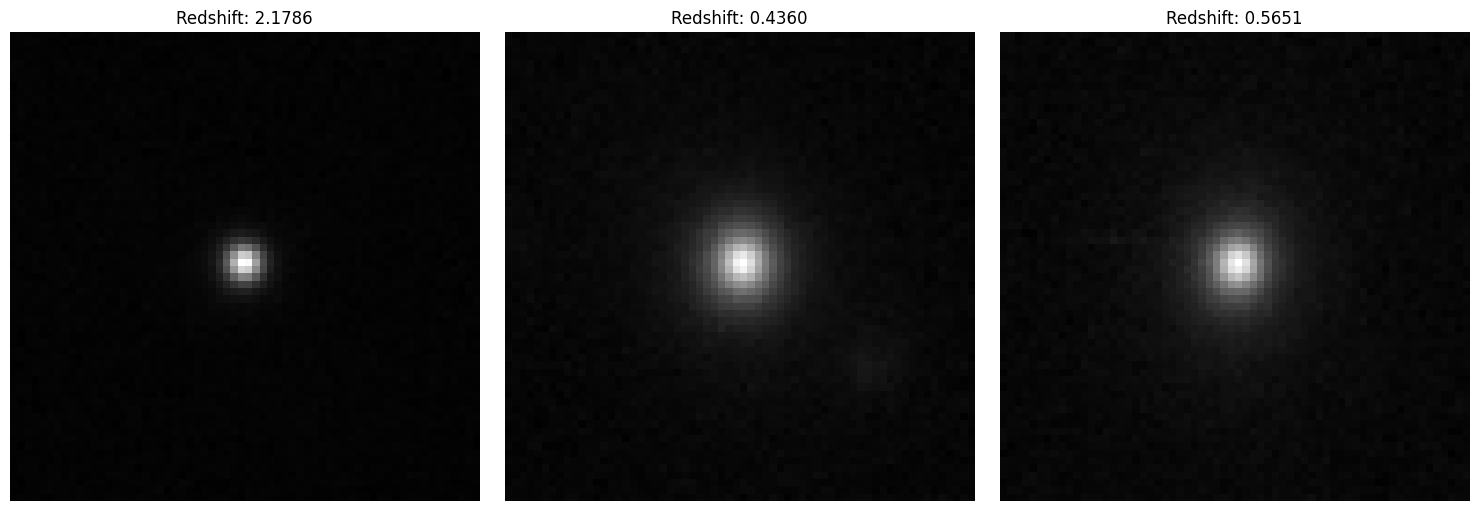

In [17]:
inspect_labels(train_dataset, device, num_samples=3)


## TensorBoard Setup

Initializes TensorBoard for training visualization and monitoring.

### Configuration
- Log directory: ./tens_logs
- Port: 6028 (adjustable)
- External access enabled
- Automatic startup with 5-second delay

Access TensorBoard at:
- Local: http://localhost:6028
- Remote: http://altair:6028 (if using Altair)

In [18]:
#Initialize and start TensorBoard
tensorboard_log_dir = "./tens_logs"
writer = SummaryWriter(tensorboard_log_dir)

tensorboard_port = 6028
tensorboard_command = [
    "tensorboard",
    f"--logdir={tensorboard_log_dir}",
    f"--port={tensorboard_port}",
    "--bind_all"
]
try:
    tensorboard_process = subprocess.Popen(tensorboard_command)
    time.sleep(5)
    print(f"TensorBoard is now running. You can access it at http://localhost:{tensorboard_port}")
    print(f"TensorBoard is now running. You can access it at http://altair:{tensorboard_port}")
except Exception as e:
    logger.error(f"Failed to start TensorBoard: {e}")


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.18.0 at http://altair:6028/ (Press CTRL+C to quit)


TensorBoard is now running. You can access it at http://localhost:6028
TensorBoard is now running. You can access it at http://altair:6028


## Checkpoint Cleanup

This function manages disk space by removing older model checkpoints. By default, it keeps the 25 most recent checkpoints and deletes older ones.

### Operation
- Finds all checkpoint files (format: checkpoint_epoch_XXXX.pth)
- Sorts them by epoch number
- Keeps the most recent 25 checkpoints (adjustable)
- Deletes all older checkpoints

### Usage
```python
# Default: keep last 25 checkpoints
cleanup_old_checkpoints(checkpoint_dir, current_epoch)

# Custom Example: keep last 10 checkpoints
cleanup_old_checkpoints(checkpoint_dir, current_epoch, keep_last_n=10)
```

This helps manage storage space during long training runs while ensuring recent progress isn't lost.

In [19]:
def cleanup_old_checkpoints(checkpoint_dir, current_epoch, keep_last_n=25):
    """
    Cleans up old checkpoints, keeping only the most recent n checkpoints.
    
    Args:
        checkpoint_dir (str): Directory containing checkpoints
        current_epoch (int): Current training epoch
        keep_last_n (int): Number of most recent checkpoints to keep
    """
   
    
    logger = logging.getLogger(__name__)
    
    try:
        # Get all checkpoint files
        checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'checkpoint_epoch_*.pth'))
        
        # Extract epoch numbers and sort files by epoch
        checkpoint_epochs = []
        for f in checkpoint_files:
            try:
                epoch_num = int(f.split('epoch_')[-1].split('.')[0])
                checkpoint_epochs.append((epoch_num, f))
            except ValueError:
                logger.warning(f"Skipping file with invalid epoch format: {f}")
                continue
        
        checkpoint_epochs.sort(key=lambda x: x[0])  # Sort by epoch number
        
        # Keep the most recent n checkpoints
        files_to_delete = checkpoint_epochs[:-keep_last_n] if len(checkpoint_epochs) > keep_last_n else []
        
        # Delete old checkpoints
        for _, filepath in files_to_delete:
            try:
                os.remove(filepath)
                logger.info(f"Deleted old checkpoint: {filepath}")
            except Exception as e:
                logger.error(f"Error deleting checkpoint {filepath}: {str(e)}")
                
        if files_to_delete:
            logger.info(f"Cleaned up {len(files_to_delete)} old checkpoints")
    
    except Exception as e:
        logger.error(f"Error during checkpoint cleanup: {str(e)}")
        logger.exception(e)


## Training Loop

This is the main training function for our diffusion model. Here's what happens during training:

### Setup Phase
- Initializes UNet model with 5 input/output channels
- Sets up AdamW optimizer and learning rate scheduler
- Configures EMA (Exponential Moving Average) for stable training
- Resumes from checkpoint if specified (args.resume = True)

### Per Epoch
1. **Training**:
   - Processes each batch of images with their redshift labels
   - Adds small noise to labels (0.01 std) for robustness
   - Trains diffusion model to predict noise
   - Updates EMA model after each step
   - Tracks loss using Huber/Smooth L1

2. **Visualization** (every 2 epochs):
   - Generates 16 new images across redshift range [0,4]
   - Shows comparison with real images
   - Saves results to TensorBoard

3. **Checkpointing**:
   - Saves model state every 2 epochs
   - Keeps best model based on validation loss
   - Cleans up old checkpoints every 50 epochs (keeps last 25)

4. **Validation**:
   - Evaluates model on validation set
   - Updates learning rate based on validation loss
   - Saves new best model if validation improves

### Monitoring
All progress is tracked in:
- Console output with progress bars
- TensorBoard logs (losses, images, learning rate)
- Detailed log files

The training can be resumed at any point using saved checkpoints.

In [20]:
def train(args, lr, ema_decay, train_loader, val_loader, writer):
    """
    Main training function for the diffusion model.
    
    Args:
        args: Configuration arguments (epochs, batch_size, etc.)
        lr: Learning rate
        ema_decay: Exponential Moving Average decay rate
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        writer: TensorBoard writer for logging
    """
    
    # =========================
    # Logger Setup
    # =========================
    # Get the logger for this module
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    
    # Set up handlers if they don't exist
    if not logger.handlers:
        # Console output handler
        ch = logging.StreamHandler()
        ch.setLevel(logging.INFO)
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        logger.addHandler(ch)
        
        # File output handler - saves to training.log
        fh = logging.FileHandler('training.log')
        fh.setLevel(logging.INFO)
        fh.setFormatter(formatter)
        logger.addHandler(fh)
    
    # Filter out repetitive messages from console output
    class MessageFilter(logging.Filter):
        def filter(self, record):
            excluded_messages = [
                "Successfully logged images to TensorBoard",
                "Successfully logged real images to TensorBoard",
                "Generating and logging images for epoch",
                "Generated images range:",
                "Starting training, logs will be written to",   
            ]
            return not any(msg in record.msg for msg in excluded_messages)
    
    # Apply filter only to console output
    for handler in logger.handlers:
        if isinstance(handler, logging.StreamHandler):
            handler.addFilter(MessageFilter())
    
    # =========================
    # Model Setup
    # =========================
    # Setup device and directories
    device = torch.device(args.device)
    checkpoint_dir = './Model_Checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    logger.info(f"Starting training, logs will be written to: {writer.log_dir}")
    
    # Initialize UNet model with 5 input/output channels (g,r,i,z,y bands)
    model = UNet_conditional_conv(c_in=5, c_out=5, y_dim=1).to(device)
    # AdamW optimizer with specified learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    # Reduce learning rate when validation loss plateaus
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    
    # Initialize Exponential Moving Average of model weights
    ema = EMA(model, beta=ema_decay)
    ema_model = ema.get_ema_model()
    
    # Initialize diffusion process
    diffusion = Diffusion(img_size=args.image_size, device=device)
    
    # =========================
    # Checkpoint Loading
    # =========================
    best_val_loss = float('inf')
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    
    start_epoch = 0
    if args.resume:
        # Load previous training state if resuming
        start_epoch = load_checkpoint(
            model, ema, optimizer, checkpoint_dir, args, diffusion, device, args.start_epoch
        )
        # Try to load previous best validation loss
        try:
            best_model_checkpoint = torch.load(best_model_path, map_location=device)
            best_val_loss = best_model_checkpoint.get('val_loss', float('inf'))
            logger.info(f"Loaded previous best validation loss: {best_val_loss:.4f}")
        except Exception as e:
            logger.warning(f"Could not load previous best validation loss: {e}, starting from infinity")
    
    # =========================
    # Training Loop Setup
    # =========================
    total_epochs = args.epochs
    cumulative_loss = 0.0
    total_start_time = time.time()
    
    logger.info(f"Training started, total epochs: {total_epochs}")
    writer.add_text('Run Info', f"Starting training for {total_epochs} epochs.", 0)
    writer.flush()
    
    generated_images = None
    
    # =========================
    # Main Training Loop
    # =========================
    for epoch in range(start_epoch, total_epochs):
        # Clear console output periodically for cleanliness
        if (epoch + 1) % 5 == 0:
            clear_output(wait=True)
            
        epoch_start_time = time.time()
        model.train()  # Set model to training mode
        epoch_loss = 0.0
        
        # Process each batch with progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{total_epochs}") as pbar:
            for i, (images, labels) in enumerate(pbar):
                # Move data to correct device
                images = images.to(device)
                labels = labels.float().to(device)
                
                # Ensure labels have correct shape
                if labels.dim() == 0:
                    labels = labels.unsqueeze(0).unsqueeze(1)
                elif labels.dim() == 1:
                    labels = labels.unsqueeze(1)
                
                # Add small noise to labels for robustness
                labels += torch.randn_like(labels) * 0.01
                labels = torch.clamp(labels, 0, 4)
                
                # Get random timesteps and add noise to images
                t = diffusion.sample_timesteps(images.shape[0]).to(device)
                x_t, noise = diffusion.noise_images(images, t)
                
                # Predict noise and calculate loss
                predicted_noise = model(x_t, t, labels)
                loss = nn.functional.smooth_l1_loss(noise, predicted_noise)
                
                # Optimization step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Update EMA model
                ema.step_ema(ema_model, model)
    
                epoch_loss += loss.item()
                pbar.set_postfix(HuberLoss=loss.item())
                
                # Periodic TensorBoard updates
                if i % 10 == 0:
                    writer.flush()
    
        # =========================
        # End of Epoch Processing
        # =========================
        # Calculate average loss for epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        cumulative_loss += avg_epoch_loss
        
        # Log training metrics
        writer.add_scalar('Loss/train_epoch', avg_epoch_loss, epoch)
        writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
        writer.flush()
    
        # =========================
        # Image Generation & Logging
        # =========================
        if (epoch + 1) % 2 == 0:
            logger.info(f"Generating and logging images for epoch {epoch + 1}")
            
            # Generate new images
            try:
                with torch.no_grad():
                    # Generate 16 images across redshift range 0-4
                    sample_labels = torch.linspace(0, 4, 16).to(device).unsqueeze(1)
                    generated_images = diffusion.sample(ema_model, 16, sample_labels)
                    generated_images = denormalize_images(generated_images)
                    
                    # Prepare images for visualization
                    generated_images_rgb = generated_images[:, :3]
                    generated_images_rgb = (generated_images_rgb - generated_images_rgb.min()) / (generated_images_rgb.max() - generated_images_rgb.min() + 1e-5)
                    
                    logger.info(f"Generated images range: [{generated_images_rgb.min():.3f}, {generated_images_rgb.max():.3f}]")
                    
                    # Log to TensorBoard
                    grid = make_grid(generated_images_rgb, nrow=4)
                    writer.add_image(f'Generated_Images/epoch_{epoch + 1}', grid, epoch)
            except Exception as e:
                logger.error(f"Error during image generation: {str(e)}")
                logger.exception(e)
            
            # Log real images for comparison
            try:
                if val_loader is not None:
                    real_images, _ = get_random_val_batch(val_loader)
                    if real_images is not None:
                        real_images = real_images.to(device)[:16]
                        real_images_rgb = real_images[:, :3]
                        real_images_rgb = (real_images_rgb - real_images_rgb.min()) / (real_images_rgb.max() - real_images_rgb.min() + 1e-5)
                        grid_real = make_grid(real_images_rgb, nrow=4)
            
                        writer.add_image(f'Real_Images/epoch_{epoch + 1}', grid_real, epoch)
                        logger.info("Successfully logged real images to TensorBoard")
                    else:
                        logger.warning("No real images obtained for logging.")
            except Exception as e:
                logger.error(f"Error during real image logging: {str(e)}")
                logger.exception(e)
            
            writer.flush()
            logger.info("Successfully logged images to TensorBoard")
            
            # Save checkpoint
            save_checkpoint(
                model=model,
                ema=ema,
                optimizer=optimizer,
                epoch=epoch,
                checkpoint_dir=checkpoint_dir,
                args=args,
                average_loss=avg_epoch_loss,
                diffusion=diffusion,
                best_val_loss=best_val_loss   
            )
            
            # Periodic cleanup of old checkpoints
            if (epoch + 1) % 50 == 0:
                logger.info(f"Performing checkpoint cleanup at epoch {epoch + 1}")
                cleanup_old_checkpoints(checkpoint_dir, epoch, keep_last_n=25)
    
        # =========================
        # Validation
        # =========================
        if val_loader is not None:
            val_loss = validate(model, val_loader, diffusion, device, torch.nn.functional.smooth_l1_loss)
            scheduler.step(val_loss)
            
            # Log validation metrics
            writer.add_scalar('Loss/validation', val_loss, epoch)
            writer.add_scalar('Best_Val_Loss', best_val_loss, epoch)
            
            # Save best model if validation improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                save_best_model(
                    model=model,
                    ema=ema,
                    optimizer=optimizer,
                    epoch=epoch,
                    val_loss=val_loss,
                    best_model_path=best_model_path,
                    args=args,
                    average_loss=avg_epoch_loss,
                    diffusion=diffusion
                )
                logger.info(f"New best model saved with validation loss {best_val_loss:.4f}")
            else:
                logger.debug(f"Validation loss {val_loss:.4f} did not improve best {best_val_loss:.4f}")
    
        writer.flush()
    
        # Log epoch timing
        epoch_end_time = time.time()
        logger.debug(
            f"Epoch {epoch + 1}/{total_epochs} finished with average loss: {avg_epoch_loss:.4f} "
            f"in {epoch_end_time - epoch_start_time:.2f} seconds"
        )
    
    # =========================
    # Final Cleanup and Logging
    # =========================
    total_training_time = time.time() - total_start_time
    final_avg_loss = cumulative_loss / total_epochs
    
    # Log final metrics
    writer.add_scalar('Loss/final_average', final_avg_loss, total_epochs)
    writer.add_text('Training Time', f'Total training time: {total_training_time:.2f} seconds')
    writer.flush()
    
    logger.info(
        f"Training completed in {total_training_time:.2f} seconds with "
        f"average loss: {final_avg_loss:.4f}"
    )
    
    return final_avg_loss, generated_images

## Start Training

This cell starts the training process by calling our training function with the configured parameters.

### Parameters Used:
- Arguments from args class (epochs, batch_size, etc.)
- Learning rate: 5e-5 (from args.lr)
- EMA decay: 0.995 (for model averaging stability)
- Training data loader
- Validation data loader
- TensorBoard writer for logging

### Returns:
- average_loss: Final training loss
- generated_images: Last batch of generated galaxies

Monitor progress in:
- Terminal output
- TensorBoard (http://localhost:6028)
- Log files in './Logs'

In [ ]:
# Call train function and pass the witer
average_loss, generated_images = train(
    args,
    lr=args.lr,
    ema_decay=0.995,
    train_loader=train_loader,  # Ensure train_dataloader is defined
    val_loader=val_loader,      # Ensure val_dataloader is defined
    writer=writer                   # Pass the SummaryWriter instance
)

 

Epoch 246/600: 100%|██████████| 1599/1599 [04:05<00:00,  6.52it/s, HuberLoss=0.0358]
999it [00:10, 96.77it/s]
Epoch 248/600:  55%|█████▍    | 878/1599 [02:13<01:51,  6.49it/s, HuberLoss=0.0164]

## TensorBoard Cleanup

This cell defines and registers an automatic cleanup function for TensorBoard.

### When Cleanup Occurs:
The TensorBoard process will terminate when:
- You shutdown the Jupyter kernel
- You close and disconnect from the server
- You restart the kernel

It will NOT terminate when:
- You finish running all cells
- You close just the browser tab
- You're idle in the notebook

For clean shutdown, either:
- Use Kernel -> Shutdown in Jupyter
- Properly disconnect from server
- Use Kernel -> Restart

Otherwise, TensorBoard will continue running in the background.

In [43]:
def shutdown_tensorboard():
    tensorboard_process.terminate()
    tensorboard_process.wait()
    logger.info("TensorBoard has been terminated.")

atexit.register(shutdown_tensorboard)

<function __main__.shutdown_tensorboard()>